In [1]:
import pandas as pd
import numpy as np
import re
import os
import torch

from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, pipeline

from tqdm.notebook import tqdm
tqdm.pandas()
import warnings
warnings.simplefilter("ignore")

## Load data

In [2]:
file_path = r"/home/voldemort/data_science/projects/basics/workshop/data/amazon_uk_shoes_products_dataset_2021_12.csv"

In [3]:
def get_gender(x):
    if "women" in x.lower():
        return "women"
    elif "men" in x.lower():
        return "men"
    elif "boy" in x.lower():
        return "boy"
    elif "girl" in x.lower():
        return "girl"
    else:
        return "unisex"

In [4]:
df = pd.read_csv(file_path)
df = df.loc[~df.review_text.isna()]

# filter negative reviews. Ratings lower than 3 are considered as negative
df = df.loc[df.review_rating<3].reset_index(drop=True)
#df = df[["product_name","review_text"]]
df["brand"] = df.product_name.apply(lambda x:x.split()[0])
df["gender"] = df.product_name.apply(get_gender)

## Language identification

In [5]:
# load a llm specialised for the language detection 

language_detection_llm_name = "papluca/xlm-roberta-base-language-detection"
lang_identifier_tokenizer = AutoTokenizer.from_pretrained(language_detection_llm_name)
lang_identifier_model = AutoModelForSequenceClassification.from_pretrained(language_detection_llm_name)

In [6]:
language_dict = {
    "ar": "arabic","bg": "bulgarian","de": "german","el": "greek","en": "english","es": "spanish","fr": "french",
    "hi": "hindi","it": "italian","ja": "japanese","nl": "dutch","pl": "polish","pt": "portuguese","ru": "russian",
    "sw": "swahili","th": "thai","tr": "turkish","ur": "urdu","vi": "vietnamese","zh": "chinese"
}

def identify_language(text):

    inputs = lang_identifier_tokenizer(text, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        logits = lang_identifier_model(**inputs).logits
    
    preds = torch.softmax(logits, dim=-1)
    id2lang = lang_identifier_model.config.id2label
    vals, idxs = torch.max(preds, dim=1)
    return {id2lang[k.item()]: v.item() for k, v in zip(idxs, vals)}

In [7]:
df["language"] = df.review_text.progress_apply(identify_language)
df["language"] = df["language"].progress_apply(lambda x : list(x.keys())[0])
df["language_name"] = df.language.progress_apply(lambda x:language_dict.get(x))

  0%|          | 0/1043 [00:00<?, ?it/s]

  0%|          | 0/1043 [00:00<?, ?it/s]

  0%|          | 0/1043 [00:00<?, ?it/s]

In [8]:
df["language_name"].value_counts()

language_name
english       703
german        123
spanish       123
italian        54
french         31
japanese        4
turkish         2
portuguese      2
russian         1
Name: count, dtype: int64

## Language Translation

In [9]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [12]:
# tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
# model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-de")
# del model, tokenizer

In [13]:
# def translate(text, target_language):
#     inputs = tokenizer.encode(text, return_tensors="pt")
#     outputs = model.generate(inputs, num_beams=4, max_length=256, early_stopping=True)
#     translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

#     return translated_text

In [14]:
checkpoint = "facebook/nllb-200-distilled-600M"
model_nllb = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
tokenizer_nllb = AutoTokenizer.from_pretrained(checkpoint)

In [15]:
def get_translated_text(text,source_lang,target_lang="en_Latn"):

    source_lang += "_Latn"
    if source_lang != target_lang:
        translator = pipeline("translation", model=model_nllb, tokenizer=tokenizer_nllb,src_lang=source_lang,tgt_lang=target_lang, max_length = 512,
                          device = "cuda"
                          )
        output = translator(text)
        translated_text = output[0]["translation_text"]
        return translated_text  
    else:
        return text

In [16]:
df["reviews_processed"] = df.progress_apply(lambda x:get_translated_text(x.review_text,source_lang=x.language),axis=1)

  0%|          | 0/1043 [00:00<?, ?it/s]

Your input_length: 742 is bigger than 0.9 * max_length: 512. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


In [17]:
df[["review_text","language","language_name","reviews_processed"]].head()

,review_text,language,language_name,reviews_processed
0,"The shoes are very cute, but after the 2nd day...",en,english,"The shoes are very cute, but after the 2nd day..."
1,Sono solita comprare scarpe Guess e non ho mai...,it,italian,"Guess i never had any problems with the size, ..."
2,This is the second pair I bought. Loved the fi...,en,english,This is the second pair I bought. Loved the fi...
3,I would NOT recommend these for running. They ...,en,english,I would NOT recommend these for running. They ...
4,These shoes are cute online but in person...no...,en,english,These shoes are cute online but in person...no...


In [18]:
df.to_csv("/home/voldemort/data_science/projects/basics/workshop/data/amz_uk_shoes_processed_stage_2.csv")

## Question Answering

In [19]:
qa_chatbot = pipeline("question-answering",model="distilbert-base-cased-distilled-squad",device=0)

In [22]:
def get_root_cause(brand,gender,review_text):
    try:
        res = qa_chatbot(
            question=f"What is the issue with {brand} {gender}'s foot wear here?",
            context=review_text
            )
        
        return res.get("answer","unknown")
    except Exception as e:
        return "unknown"

In [23]:
df["root_cause"] = df.progress_apply(lambda x:get_root_cause(x.brand,x.gender,x.reviews_processed),axis=1)

  0%|          | 0/1043 [00:00<?, ?it/s]

In [28]:
df = df.loc[~(df.root_cause=="unknown")]

In [29]:
df.to_csv("/home/voldemort/data_science/projects/basics/workshop/data/amz_uk_shoes_processed.csv")

## Word cloud

In [30]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import nltk
# if you are running this for the first time, then stop words and word net needs to be downloaded
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [36]:
def remove_stop_words(sentence):
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words_list]
    return filtered_sentence

def lemmatize_words(sentence):
    res = [lemmatizer.lemmatize(x,'v') for x in sentence]
    return res

def remove_single_letters(sentence):
    
    sentence = [x for x in sentence if len(x)>2]
    return sentence

def join_words_back(word_list):
    
    try:
        return ' '.join(word for word in word_list)
    except:
        return ' '

In [32]:
# df = pd.read_csv("/home/voldemort/data_science/projects/basics/workshop/data/amz_uk_shoes_processed.csv")

In [33]:
#stopwords = set(STOPWORDS)
stop_words_list = stopwords.words('english')

In [34]:
df["description"] = df["root_cause"].apply(lambda x:x.replace("shoe","").lower())

In [35]:
processed_text_column_name = "description"
df[processed_text_column_name] = df[processed_text_column_name].apply(remove_stop_words)
df[processed_text_column_name] = df[processed_text_column_name].apply(lemmatize_words)
df[processed_text_column_name] = df[processed_text_column_name].apply(remove_single_letters)
df[processed_text_column_name] = df[processed_text_column_name].apply(join_words_back)

In [37]:
df[[processed_text_column_name]].head()

,description
0,tongue start rip
1,small
2,pad
3,zero support
4,super light weight flimsy feel


In [38]:
comment_words = ''

for val in df.description:
     
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

In [49]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stop_words_list,
                min_font_size = 10).generate(comment_words)

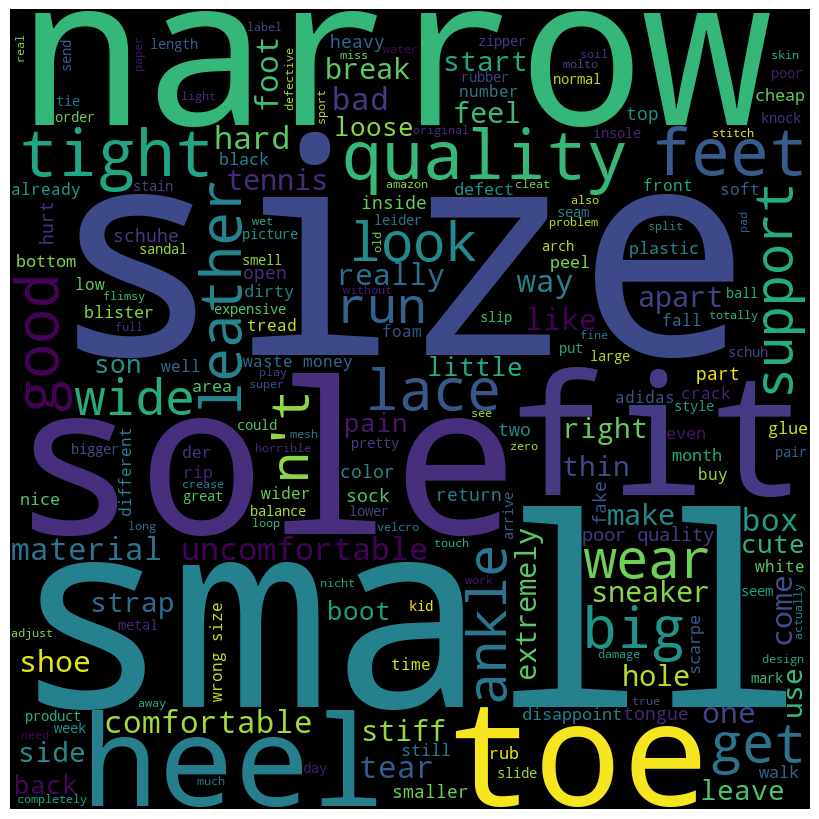

In [50]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)